In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy.io
import scipy.signal

In [2]:
index_files_path = 'SFootBD/IndexFiles/'
data_files_path = 'SFootBD/SFootBD/'

train_list_file = index_files_path + 'LstTrain'
imposter_list_file = index_files_path + 'LstImp'
test_evaluation_list_file = index_files_path + 'LstTestEvaluation'
test_validation_list_file = index_files_path + 'LstTestValidation'

In [3]:
train_list = pd.read_csv(train_list_file, sep = ' ', header = None)

train_list.head()

,0,1
0,15,2007-05-22_16-35-52_693
1,15,2007-05-22_16-24-39_584
2,15,2007-05-22_16-35-41_215
3,15,2007-05-22_16-24-29_028
4,15,2007-05-22_16-24-50_450


In [4]:
mat_file = os.path.join(data_files_path, train_list[1][0] + '.mat')

mat = scipy.io.loadmat(mat_file)

In [5]:
def foot_reshape(arr):
    # 88 + 3 zeros = 91 which is reshaped to 13 x 7
    arr = np.append(arr, np.zeros((arr.shape[0], 3)), axis = 1)
    
    return np.reshape(arr, (arr.shape[0], 13, 7))

In [6]:
# Left footstep
dataL = foot_reshape(mat['dataL'])

# Right footstep
dataR = foot_reshape(mat['dataR'])

In [7]:
Tmax = 1600

spatial = dataL[:Tmax]

# Accumulated Pressure gives spatial representation
spatial = np.add.accumulate(np.abs(spatial), axis = 0)
spatial = np.sum(spatial, axis = 0)

In [8]:
spatial_max = np.max(spatial)

# Scale to [0, 1]
spatial /= spatial_max

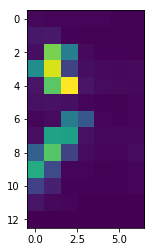

In [9]:
# Spatial representation
plt.imshow(spatial)

C:\Users\Mathew\Anaconda2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


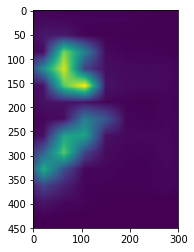

In [10]:
from skimage.transform import resize

# 45 mm x 30 mm
scaled_spatial_img = resize(spatial, (450, 300))

plt.imshow(scaled_spatial_img)

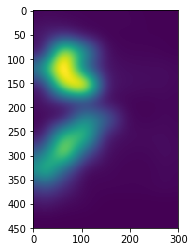

In [11]:
import scipy.ndimage

# Smoothening using Gaussian filter
# Doing here only for the purpose of calculating center and rotation angle
# Will be actually applied on output after translation and rotation
processed_spatial = scipy.ndimage.gaussian_filter(scaled_spatial_img, sigma = 14)

plt.imshow(processed_spatial)

In [12]:
front = processed_spatial[:225]
heel = processed_spatial[225:]

front_max = np.unravel_index(np.argmax(front), front.shape)

print front_max

heel_max = np.unravel_index(np.argmax(heel), heel.shape)

heel_max = (heel_max[0] + 225, heel_max[1])

print heel_max

(123, 64)
(283, 66)


In [13]:
import math

req_center = (processed_spatial.shape[0] / 2, processed_spatial.shape[1] / 2)

angle = math.atan2(heel_max[0] - front_max[0], heel_max[1] - front_max[1])
center = ((front_max[0] + heel_max[0])/2, (front_max[1] + heel_max[1])/2)

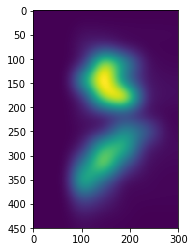

In [14]:
dx = center[0] - req_center[0]
dy = center[1] - req_center[1]
req_angle = math.pi / 2
theta = req_angle - angle

transform_mat = np.array([
    [math.cos(theta), -math.sin(theta), dx],
    [math.sin(theta), math.cos(theta), dy]
])

transformed = scipy.ndimage.affine_transform(scaled_spatial_img, transform_mat)

transformed = scipy.ndimage.gaussian_filter(transformed, sigma = 14)

plt.imshow(transformed)